In [1]:
%autosave 100

import numpy as np
import math
import matplotlib.pyplot as plt

Autosaving every 100 seconds


In [2]:
# step: 1 at(0, 5), 0 at(5, 10)
# Начальное распределение температуры
def func0(x):
    return 1 if x < 5 else 0

#    __
#   /  \
# _/    \_
def func1(x):
    if (x < 2):
        return 0
    elif (x < 4):
        return x / 2 - 1
    elif (x < 6):
        return 1
    elif (x < 8):
        return - x / 2 + 4
    else:
        return 0

In [3]:
def explicit(T_pred, coefs):
    n = len(T_pred)
    res = np.zeros(n - 2)
    for i in range(1, n - 1):
        res[i - 1] = coefs[0] * T_pred[i - 1] + coefs[1] * T_pred[i] + coefs[2] * T_pred[i + 1]
    return res

# Явная схема против потока
def downstream_coefs(r, s):
    return (r + s, 1 - 2 * r - s, r)

def explicit_downstream(T_pred, r, s):
    return explicit(T_pred, downstream_coefs(r, s))

# Явная схема по потоку
def upstream_coefs(r, s):
    return (r, 1 - 2 * r + s, r - s)

def explicit_upstream(T_pred, r, s):
    return explicit(T_pred, upstream_coefs(r, s))

In [4]:
def tridiagonal_sweep(a, b, c, rhs):
    n = len(rhs)
    assert n >= 3
    coefs = [(b, c)]
    cur, nxt = b, c
    for i in range(1, n):
        rhs[i] = cur * rhs[i] - a * rhs[i - 1]
        cur, nxt = b * cur - a * nxt, c * cur
        coefs.append((cur, nxt))
        
    res = np.zeros([n])
    res[-1] = rhs[-1] / cur
    for i in range(n - 2, -1, -1):
        res[i] = (rhs[i] - coefs[i][1] * res[i + 1]) / coefs[i][0]
    return res

In [5]:
def implicit(T_pred, coefs):
    a, b, c = coefs
    rhs = T_pred[1:-1].copy()
    rhs[0] -= a * T_pred[0]
    rhs[-1] -= c * T_pred[-1]
    return tridiagonal_sweep(a, b, c, rhs)

def implicit_downstream(T_pred, r, s):
    return implicit(T_pred, downstream_coefs(-r, -s))

def implicit_upstream(T_pred, r, s):
    return implicit(T_pred, upstream_coefs(-r, -s))

In [7]:
times = 20
dt = 1
x_max = 10
dx = 0.25
u = 0.1
kappa = 0.1

steps = round(10 / dx)
s = u * dt / dx
r = kappa * dt / dx / dx

methods = {
    'Явный по потоку': explicit_upstream, 
    'Явный против потока': explicit_downstream,
    'Неявный по потоку': implicit_upstream,
    'Неявный против потока': implicit_downstream
}

T = np.zeros([times, steps], dtype = float)
xs = np.arange(0, x_max, dx)

for (i,x) in enumerate(xs):
    T[0,i] = func1(x)    

In [ ]:
for m in methods:
    print(m)
    for time in range(times):
        if time > 0:
            T[time, 0] = func1(0)
            T[time, -1] = func1(x_max)
            T[time, 1:-1] = methods[m](T[time - 1, :], r, s)
        plt.scatter(xs, T[time,:])
        plt.show()
    

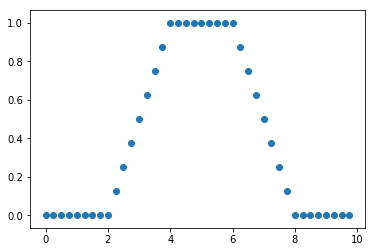

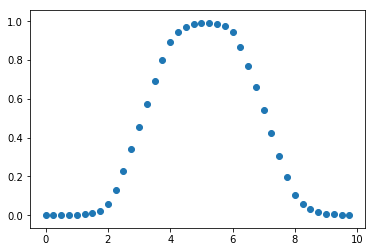

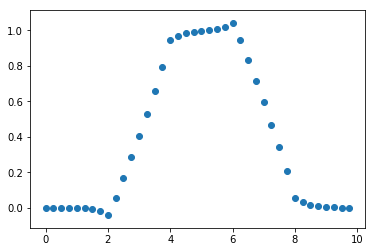

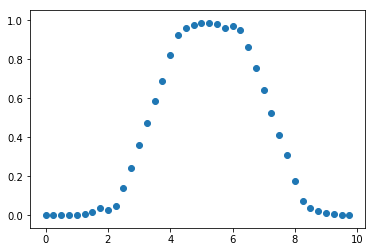

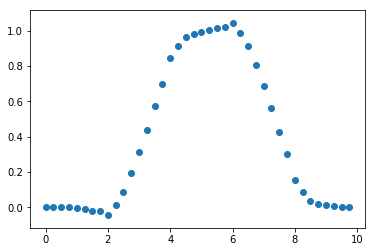

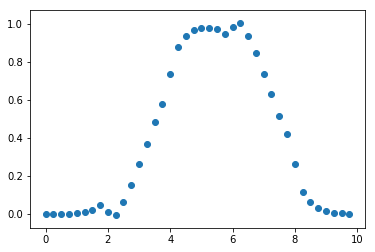

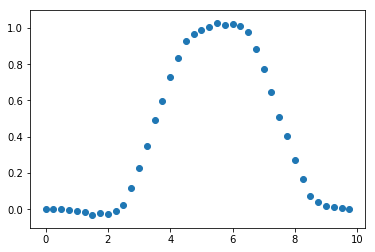

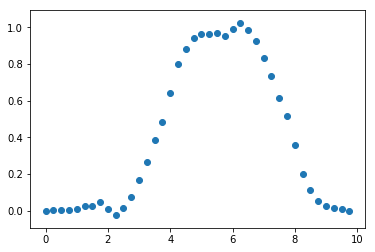

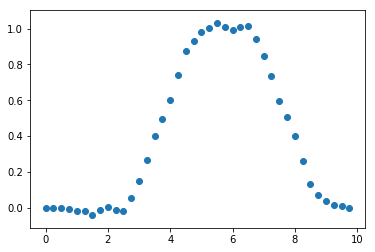

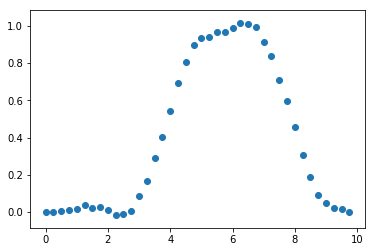

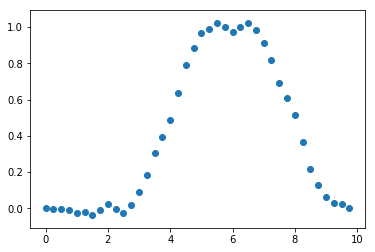

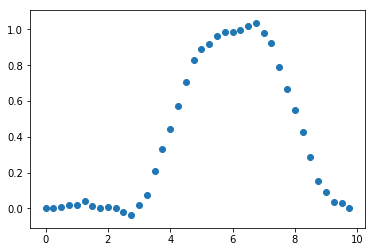

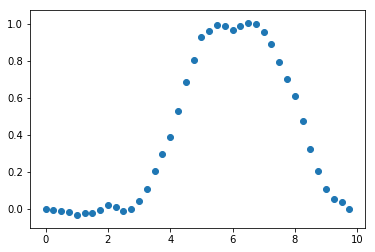

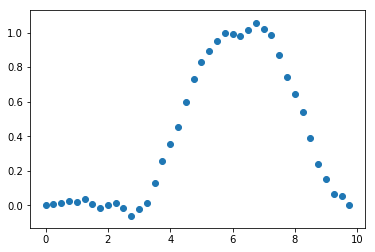

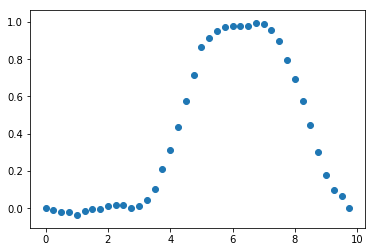

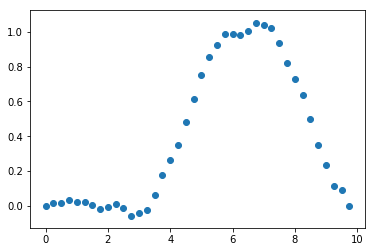

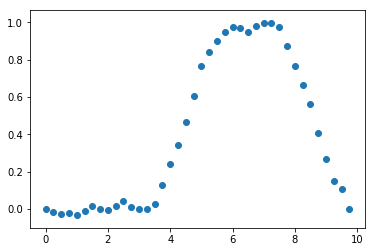

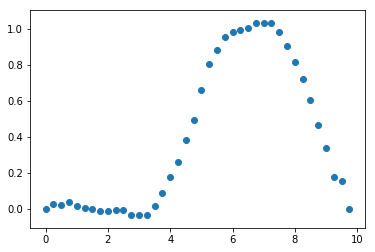

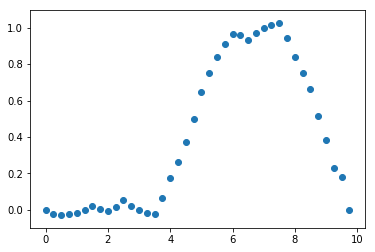

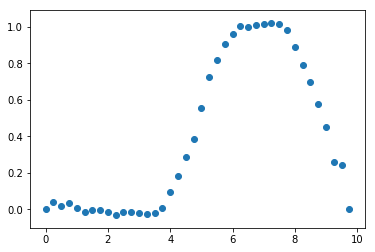

In [8]:
# manual1: http://mash-xxl.info/page/037106102150078245014092020230082163118095238104/
# manual2: http://crecs.ru/ru/numlabs2/Advect_index.html

for time in range(0, times):
    if time > 1: 
        T[time, 0] = func1(0)
        T[time, -1] = func1(x_max)
        for x in range(1, len(xs) - 1):
            T[time, x] = T[time - 2][x] - s * (T[time - 1][x + 1] - T[time - 1][x - 1])
    elif time == 1:
        T[time, 0] = func1(0)
        T[time, -1] = func1(x_max)
        T[time, 1:-1] = implicit_downstream(T[time - 1, :], r, s)
    
    plt.scatter(xs, T[time,:])
    plt.show()